In [1]:
!pip install pandas geopandas pyshp shapely

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 37.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 77.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 109.8 MB/s eta 0:00:00


In [2]:
!pip install awscli
!aws configure
!mkdir spacenet7
!aws s3 sync --no-sign-request --quiet s3://spacenet-dataset/spacenet/SN7_buildings/ spacenet7

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 76.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 102.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.1/175.1 kB 12.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for PyYAML: filename=PyYAML-5.4.1-cp310-cp310-linux_x86_64.whl size=45658 sha256=e705e0953ed04624d20bbfdea199842bfaf1fedb20d7946172706a4e00536698
  Stored in directory: /root/.cache/pip/wheels/c7/0d/22/696ee92245ad710f506eee79bb05c740d8abccd3ecdb778683
Successfully built PyYAML
  Attempting uninstall: rsa
    Found existing installation: rsa 4.9
    Uninstalling rsa-4.9:
      Successfully uninstalled rsa-4.9
  Attempting uni

In [3]:
!tar -xzf /content/spacenet7/tarballs/SN7_buildings_train_sample.tar.gz

In [1]:
!git clone https://github.com/tensorflow/models.git
%cd /content/models/research
# Compile protos.
!protoc object_detection/protos/*.proto --python_out=.
# Install TensorFlow Object Detection API.
!cp object_detection/packages/tf2/setup.py .
!python -m pip install .
%cd /content/models/research/object_detection
!python /content/models/research/object_detection/builders/model_builder_tf2_test.py

fatal: destination path 'models' already exists and is not an empty directory.
/content/models/research
ERROR: Operation cancelled by user
/content/models/research/object_detection
2023-05-13 22:22:38.305776: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-13 22:22:39.713228: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow com

In [ ]:

import os
os.kill(os.getpid(), 9)


In [1]:
%cd /content

/content


In [2]:
with open('label_map.pbtxt', 'w') as f:
    f.write('item {\n')
    f.write('  id: 1\n')
    f.write("  name: 'building'\n")
    f.write('}\n')


In [3]:
import numpy as np

def geojson_to_bounding_boxes(labels):
    bounding_boxes = []

    for feature in labels['features']:
        geometry = feature['geometry']
        if geometry['type'] == 'Polygon':
            coordinates = np.array(geometry['coordinates'][0])

            # Find the minimum and maximum coordinates to create a bounding box
            xmin = np.min(coordinates[:, 0])
            ymin = np.min(coordinates[:, 1])
            xmax = np.max(coordinates[:, 0])
            ymax = np.max(coordinates[:, 1])

            bounding_box = {'xmin': xmin, 'ymin': ymin, 'xmax': xmax, 'ymax': ymax}
            bounding_boxes.append(bounding_box)

    return bounding_boxes


In [4]:
import os
import glob
import cv2
import json

# Set up the directory paths
dataset_path = "/content/spacenet7/train"
images_path = os.path.join(dataset_path, "images")
labels_path = os.path.join(dataset_path, "labels_match_pix")

# Define the output directories for preprocessed data
output_images_dir = "/content/sample/processed/images"
output_labels_dir = "/content/sample/processed/labels"

# Create the output directories if they do not exist
os.makedirs(output_images_dir, exist_ok=True)
os.makedirs(output_labels_dir, exist_ok=True)

# Define the desired image size
image_size = (512, 512)

def load_preprocessed_data(dataset_path, output_images_dir, output_labels_dir):
    images = []
    labels = []

    # Iterate through each folder in the dataset
    for folder in os.listdir(dataset_path):
        images_path = os.path.join(dataset_path, folder, "images")
        labels_path = os.path.join(dataset_path, folder, "labels_match_pix")

        # Create the output directories for this folder
        folder_output_images_dir = os.path.join(output_images_dir, folder)
        folder_output_labels_dir = os.path.join(output_labels_dir, folder)
        os.makedirs(folder_output_images_dir, exist_ok=True)
        os.makedirs(folder_output_labels_dir, exist_ok=True)

        # Iterate through each image in the folder
        for image_file in glob.glob(os.path.join(images_path, "*.tif")):
            # Load the image
            image = cv2.imread(image_file)

            # Resize the image
            image = cv2.resize(image, image_size)

            # Save the preprocessed image
            image_name = os.path.basename(image_file).split(".")[0] + ".jpg"
            cv2.imwrite(os.path.join(folder_output_images_dir, image_name), image)
            images.append(image)

            # Load the corresponding labels
            labels_file = os.path.join(labels_path, image_name.replace(".jpg", "_Buildings.geojson"))
            with open(labels_file) as f:
                label_data = json.load(f)

            # Convert labels to bounding boxes
            bounding_boxes = geojson_to_bounding_boxes(label_data)

            # Save the preprocessed labels
            labels_name = os.path.basename(labels_file).replace(".geojson", ".json")
            with open(os.path.join(folder_output_labels_dir, labels_name), "w") as f:
                json.dump(bounding_boxes, f)
            labels.append(bounding_boxes)

    return images, labels

# Load the preprocessed images and labels
images, labels = load_preprocessed_data(dataset_path, output_images_dir, output_labels_dir)


In [5]:
from sklearn.model_selection import train_test_split

train_images, val_images, train_labels, val_labels = train_test_split(images, labels, test_size=0.2, random_state=42)


In [6]:
from sklearn.model_selection import train_test_split

train_images, val_images, train_labels, val_labels = train_test_split(images, labels, test_size=0.2, random_state=42)

train_folder = "/content/sample/train"
val_folder = "/content/sample/val"

os.makedirs(train_folder, exist_ok=True)
os.makedirs(val_folder, exist_ok=True)

# Save train_images and train_labels in the train folder
for idx, (img, lbl) in enumerate(zip(train_images, train_labels)):
    img_name = f"train_image_{idx}.jpg"
    lbl_name = f"train_label_{idx}.json"
    
    cv2.imwrite(os.path.join(train_folder, img_name), img)
    with open(os.path.join(train_folder, lbl_name), "w") as f:
        json.dump(lbl, f)

# Save val_images and val_labels in the val folder
for idx, (img, lbl) in enumerate(zip(val_images, val_labels)):
    img_name = f"val_image_{idx}.jpg"
    lbl_name = f"val_label_{idx}.json"
    
    cv2.imwrite(os.path.join(val_folder, img_name), img)
    with open(os.path.join(val_folder, lbl_name), "w") as f:
        json.dump(lbl, f)


In [7]:
def read_json_file(json_file_path):
    with open(json_file_path, 'r') as file:
        data = json.load(file)
    return data

def write_json_file(json_file_path, data):
    with open(json_file_path, 'w') as file:
        json.dump(data, file)


def normalize_coordinates(bbox, img_width, img_height):
    normalized_bbox = {}
    
    normalized_bbox["xmin"] = bbox["xmin"] / img_width
    normalized_bbox["ymin"] = bbox["ymin"] / img_height
    normalized_bbox["xmax"] = bbox["xmax"] / img_width
    normalized_bbox["ymax"] = bbox["ymax"] / img_height
    
    return normalized_bbox

train_folder = "/content/sample/train"
val_folder = "/content/sample/val"

img_width = 512  # Width of the image
img_height = 512  # Height of the image

# Process train data
train_normalized_bboxes = []
for json_file in os.listdir(train_folder):
    if json_file.endswith(".json"):
        json_file_path = os.path.join(train_folder, json_file)
        data = read_json_file(json_file_path)
        
        # Extract bounding box information and normalize the coordinates
        for  i,bbox in enumerate(data):
            normalized_bbox = normalize_coordinates(bbox, img_width, img_height)
            train_normalized_bboxes.append(normalized_bbox)
            data[i] = normalized_bbox
        write_json_file(json_file_path, data)

# Process validation data
val_normalized_bboxes = []
for json_file in os.listdir(val_folder):
    if json_file.endswith(".json"):
        json_file_path = os.path.join(val_folder, json_file)
        data = read_json_file(json_file_path)
        
        # Extract bounding box information and normalize the coordinates
        for  i,bbox in enumerate(data):
            normalized_bbox = normalize_coordinates(bbox, img_width, img_height)
            val_normalized_bboxes.append(normalized_bbox)
        write_json_file(json_file_path, data)



In [8]:
def create_tf_example(image_file, label, label_map):
    image = cv2.imread(image_file)
    height, width, _ = image.shape

    encoded_image_data = tf.io.gfile.GFile(image_file, 'rb').read()

    filename = os.path.basename(image_file).encode('utf8')
    image_format = b'JPG'

    xmins, xmaxs, ymins, ymaxs = [], [], [], []
    classes_text, classes = [], []

    for bbox in label:
        xmins.append(bbox['xmin'] / 512)
        xmaxs.append(bbox['xmax'] / 512)
        ymins.append(bbox['ymin'] / 512)
        ymaxs.append(bbox['ymax'] / 512)
        classes_text.append(label_map[1]['name'].encode('utf8'))
        classes.append(1)

    tf_example = tf.train.Example(features=tf.train.Features(feature={
        'image/height': tf.train.Feature(int64_list=tf.train.Int64List(value=[height])),
        'image/width': tf.train.Feature(int64_list=tf.train.Int64List(value=[width])),
        'image/filename': tf.train.Feature(bytes_list=tf.train.BytesList(value=[filename])),
        'image/source_id': tf.train.Feature(bytes_list=tf.train.BytesList(value=[filename])),
        'image/encoded': tf.train.Feature(bytes_list=tf.train.BytesList(value=[encoded_image_data])),
        'image/format': tf.train.Feature(bytes_list=tf.train.BytesList(value=[image_format])),
        'image/object/bbox/xmin': tf.train.Feature(float_list=tf.train.FloatList(value=xmins)),
        'image/object/bbox/xmax': tf.train.Feature(float_list=tf.train.FloatList(value=xmaxs)),
        'image/object/bbox/ymin': tf.train.Feature(float_list=tf.train.FloatList(value=ymins)),
        'image/object/bbox/ymax': tf.train.Feature(float_list=tf.train.FloatList(value=ymaxs)),
        'image/object/class/text': tf.train.Feature(bytes_list=tf.train.BytesList(value=classes_text)),
        'image/object/class/label': tf.train.Feature(int64_list=tf.train.Int64List(value=classes)),
    }))
    return tf_example


In [9]:
import tensorflow as tf
import glob



def create_tf_records(data_folder, output_path):
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    label_map = {1: {'id': 1, 'name': 'building'}}
    
    image_files = glob.glob(os.path.join(data_folder, "*.jpg"))
    label_files = glob.glob(os.path.join(data_folder, "*.json"))

    with tf.io.TFRecordWriter(output_path) as writer:
        for image_file, label_file in zip(image_files, label_files):
            with open(label_file) as f:
                label = json.load(f)
            tf_example = create_tf_example(image_file, label, label_map)
            writer.write(tf_example.SerializeToString())

train_output_path = "/content/sample/tf_records/train.record"
val_output_path = "/content/sample/tf_records/val.record"

train_path = '/content/sample/train'
val_path = '/content/sample/val'

create_tf_records(train_path, train_output_path)
create_tf_records(val_path, val_output_path)


In [10]:
!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/faster_rcnn_resnet50_v1_640x640_coco17_tpu-8.tar.gz
!tar -xvf faster_rcnn_resnet50_v1_640x640_coco17_tpu-8.tar.gz


--2023-05-13 22:35:33--  http://download.tensorflow.org/models/object_detection/tf2/20200711/faster_rcnn_resnet50_v1_640x640_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 142.250.145.128, 2a00:1450:4013:c14::80
Connecting to download.tensorflow.org (download.tensorflow.org)|142.250.145.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 211996178 (202M) [application/x-tar]
Saving to: ‘faster_rcnn_resnet50_v1_640x640_coco17_tpu-8.tar.gz’

faster_rcnn_resnet5 100%[===================>] 202.17M   113MB/s    in 1.8s    

2023-05-13 22:35:35 (113 MB/s) - ‘faster_rcnn_resnet50_v1_640x640_coco17_tpu-8.tar.gz’ saved [211996178/211996178]

faster_rcnn_resnet50_v1_640x640_coco17_tpu-8/
faster_rcnn_resnet50_v1_640x640_coco17_tpu-8/checkpoint/
faster_rcnn_resnet50_v1_640x640_coco17_tpu-8/checkpoint/ckpt-0.data-00000-of-00001
faster_rcnn_resnet50_v1_640x640_coco17_tpu-8/checkpoint/checkpoint
faster_rcnn_resnet50_v1_640x640_coco17_tpu-8/c

In [11]:
from object_detection.utils import config_util
from object_detection.protos import pipeline_pb2
from object_detection.protos import optimizer_pb2
from google.protobuf import text_format

def modify_pipeline_config(input_config_path, output_config_path, label_map_path, train_input_path, val_input_path, batch_size=1):
    pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()
    with open(input_config_path, "r") as f:
        proto_str = f.read()
        text_format.Merge(proto_str, pipeline_config)
    
    # Add the optimizer configuration
    optimizer_config = pipeline_config.train_config.optimizer
    optimizer_config.momentum_optimizer.learning_rate.cosine_decay_learning_rate.learning_rate_base = 0.05
    optimizer_config.momentum_optimizer.learning_rate.cosine_decay_learning_rate.total_steps = 500000
    optimizer_config.momentum_optimizer.learning_rate.cosine_decay_learning_rate.warmup_learning_rate = 0.0133
    optimizer_config.momentum_optimizer.learning_rate.cosine_decay_learning_rate.warmup_steps = 3000
    optimizer_config.momentum_optimizer.momentum_optimizer_value = 0.9
    optimizer_config.use_moving_average = False

    # Other modifications
    pipeline_config.model.faster_rcnn.num_classes = 1
    pipeline_config.train_config.fine_tune_checkpoint = os.path.join('/content/faster_rcnn_resnet50_v1_640x640_coco17_tpu-8/checkpoint', "ckpt-0")
    pipeline_config.train_config.fine_tune_checkpoint_type = "detection"
    pipeline_config.train_config.batch_size = batch_size
    pipeline_config.train_input_reader.label_map_path = label_map_path
    pipeline_config.train_input_reader.tf_record_input_reader.input_path[0] = train_input_path
    pipeline_config.eval_input_reader[0].label_map_path = label_map_path
    pipeline_config.eval_input_reader[0].tf_record_input_reader.input_path[0] = val_input_path

    with open(output_config_path, "w") as f:
        f.write(text_format.MessageToString(pipeline_config))


In [12]:

# Modify the pipeline.config file
input_config_path = "/content/faster_rcnn_resnet50_v1_640x640_coco17_tpu-8/pipeline.config"
output_config_path = "/content/faster_rcnn_resnet50_v1_640x640_coco17_tpu-8/pipeline_modified.config"
label_map_path = "/content/label_map.pbtxt"
train_input_path = "/content/sample/tf_records/train.record"
val_input_path = "/content/sample/tf_records/val.record"

modify_pipeline_config(input_config_path, output_config_path, label_map_path, train_input_path, val_input_path)


In [13]:
!python /content/models/research/object_detection/model_main_tf2.py \
    --pipeline_config_path=/content/faster_rcnn_resnet50_v1_640x640_coco17_tpu-8/pipeline_modified.config \
    --model_dir=/content/training \
    --alsologtostderr \
    --num_train_steps=2000 \
    --sample_1_of_n_eval_examples=1 \
    --num_eval_steps=1000


2023-05-13 22:35:40.357044: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
2023-05-13 22:35:46.020871: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
I0513 22:35:46.056000 139984024692544 mir

In [14]:
!python /content/models/research/object_detection/exporter_main_v2.py \
    --input_type=image_tensor \
    --pipeline_config_path=/content/faster_rcnn_resnet50_v1_640x640_coco17_tpu-8/pipeline_modified.config \
    --trained_checkpoint_dir=/content/training \
    --output_directory=/content/exported_model


2023-05-13 22:42:22.760350: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
2023-05-13 22:42:31.063487: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.map_fn(fn, elems, b

In [2]:
!pip install pyngrok


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 681.2/681.2 kB 19.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyngrok: filename=pyngrok-6.0.0-py3-none-any.whl size=19867 sha256=04ff584aa5b641a7aaec3bb6d8a535433cc007a6fffff2350fd3158f616c3da5
  Stored in directory: /root/.cache/pip/wheels/5c/42/78/0c3d438d7f5730451a25f7ac6cbf4391759d22a67576ed7c2c
Successfully built pyngrok


In [3]:
from pyngrok import ngrok

# Replace YOUR_NGROK_AUTHTOKEN with your actual ngrok authtoken
ngrok.set_auth_token("2PexgqM8oqsgi5jIbhFT4g8VW3T_4QiwDxaRad967fDdPTdqF")

!tensorboard --logdir=/content/training --host=0.0.0.0 --port=6008 &
url = ngrok.connect(6008, 'http')
print("TensorBoard URL:", url)


2023-05-13 22:49:26.882686: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-13 22:49:27.896793: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-05-13 22:49:29.442736: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-13 22:49:29.516143: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returnin

TensorBoard URL: NgrokTunnel: "https://51b6-34-141-213-116.ngrok-free.app" -> "http://localhost:6008"


tf.Tensor(
[[[0.5420966  0.9756794  0.5571428  0.98166144]
  [0.4541911  0.97591877 0.4721395  0.9821026 ]
  [0.35963812 0.60535425 0.37377635 0.6111608 ]
  ...
  [0.         0.         0.         0.        ]
  [0.         0.         0.         0.        ]
  [0.         0.         0.         0.        ]]], shape=(1, 300, 4), dtype=float32)
tf.Tensor(
[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

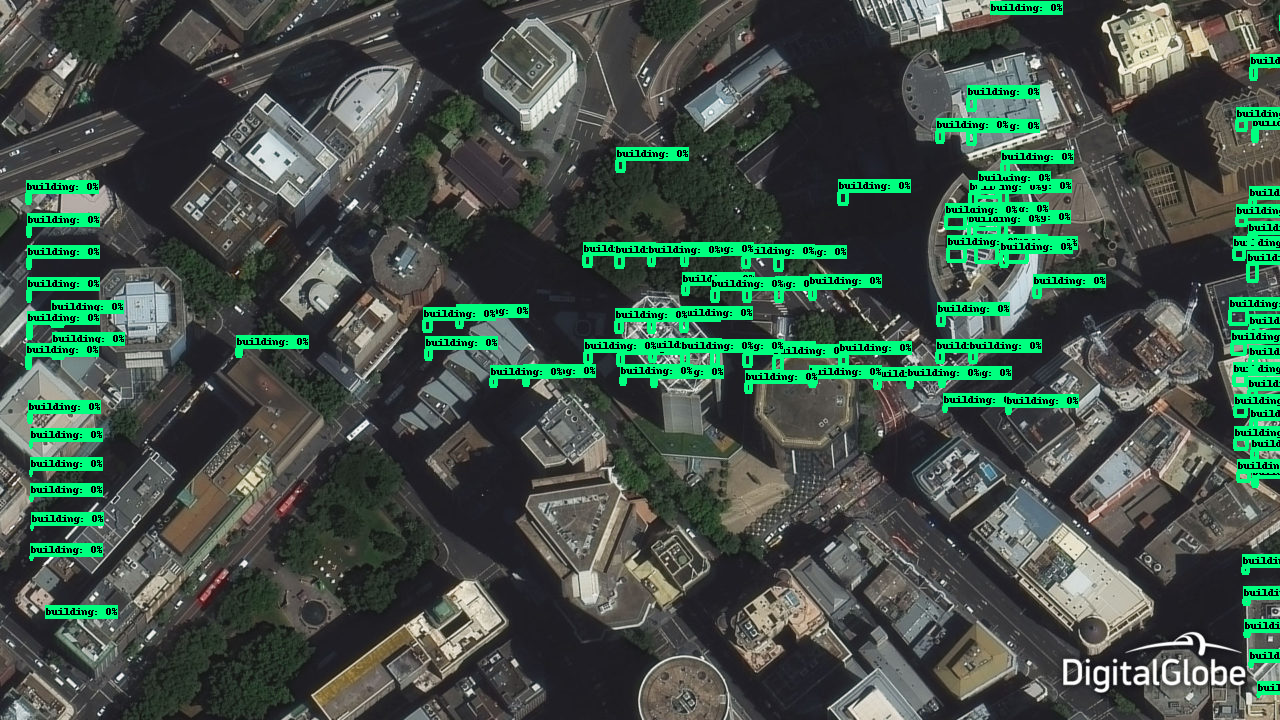

In [5]:
import tensorflow as tf
import numpy as np
import cv2
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import label_map_util


# Load the label map
category_index = label_map_util.create_category_index_from_labelmap('/content/label_map.pbtxt', use_display_name=True)

# Load the exported model
model = tf.saved_model.load('/content/exported_model/saved_model/')

# Load the image
image = cv2.imread('/content/0003_AUS_Sydney_Jan06_2015_WV3_30cm-1.jpg')



# Run inference on the image
input_tensor = np.expand_dims(image, 0)
detections = model(input_tensor)

# Print the detected boxes and classes
print(detections['detection_boxes'])
print(detections['detection_classes'])
# Convert the detections to a numpy array
num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy() for key, value in detections.items()}
detections['num_detections'] = num_detections

# Visualize the detections
viz_utils.visualize_boxes_and_labels_on_image_array(
    image,
    detections['detection_boxes'],
    detections['detection_classes'].astype(np.int32),
    detections['detection_scores'],
    category_index,
    use_normalized_coordinates=True,
    max_boxes_to_draw=200,
    min_score_thresh=0.00,
    agnostic_mode=False,
)

from google.colab.patches import cv2_imshow

# Display the image with detections
cv2_imshow(image)
cv2.waitKey(0)
cv2.destroyAllWindows()